# Selecting, smoothing, and deriving measures from motion tracking, and merging with acoustics and annotations in Python
<br>
<div align="center">Wim Pouw (wim.pouw@donders.ru.nl)</div>

<img src="./Images/envision_banner.png" alt="isolated" width="300"/>

## Info documents

* This python coding module shows some basic data wrangling procedures that are often required when analyzing motion, sound, for events bounded by annotations. These procedures include merging data streams, deriving 1-dimensional measures from high dimensional motion tracking data, accounthing for different sampling rates, and smoothing the data. We also show some simple applications once we have a multimodal dataset prepared, in the form of a simple peak analysis.

* location Repository:  https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/MultimodalMerging

* location Jupyter notebook: https://github.com/WimPouw/envisionBOX_modulesWP/blob/main/MultimodalMerging/MergingMultimodal_inPython.ipynb

* citation: Pouw, W. (2023). *Selecting, smoothing, and deriving measures from motion tracking, and merging with acoustics and annotations*. [the day you viewed the site]. Retrieved from: https://envisionbox.org/embedded_MergingMultimodal_inPython.html

## Background

In multimodal analysis you will often encounter the situation that you have signals that are continuous but sampling at different rates, and such signals then also need to be related to qualitative codings such as ELAN gesture annotations, or trial information of your experiment. It is sometimes convenient to have everything you need in one time series file, so you can apply your multimodal analysis easily. A lot of the initial steps of even beginning to do some quantitative multimodal recording and analysis are covered in Pouw, Trujillo, Dixon (2020); here we provide some basic data wrangling steps that are often required to set up your dataset (e.g., merging data, smoothing data, extracting kinematic variables). 

In [1]:
## Video Tutorial (from envision bootcamp 2021)
#from IPython.display import YouTubeVideo
#YouTubeVideo('https://youtu.be/0uAa10VbVes?list=PL8vb5RWWmZQCWjjnP2HQT4kPI2Q5XKB0D', width=400, height=300)
# We will update this after the summer school

## Set up folders and check data formats

For this module we will only demonstrate the steps for the cartoon retelling example that we have in our multimedia samples. For this sample we have already generated 

* A) a motion tracking time series for a bunch of body keypoints sampling at 30Hz
* B) an amplitude envelope time series of speech which was sampled at 100Hz
* C) Then we also have annotations of the dominant hand (right handed gestures) that this person produced. 

So here we show a way to merge A, B, and C, in a way that is convenient for further analysis. Lets first identify the relevant files and set the relevant folders.

In [44]:
import os            #folder designating
import pandas as pd  #data wrangling and data framing
import glob as glob

curfolder = os.getcwd() #get current working folder

#This is the folder where your merged output is saved                                                 
outputfolder = curfolder + "/output/"

# input folder
inputfolder = curfolder + "/Input/"
print(inputfolder)

# first check videofile
videofile = glob.glob(inputfolder + "*.mp4")[0]

# MT 
MTfiles = glob.glob(inputfolder + "*_body.csv")
ANNO = glob.glob(inputfolder + "*_segments.csv")

# read in with pandas
MT = pd.read_csv(MTfiles[0])
ANNO = pd.read_csv(ANNO[0])

print("The data we have are the motion tracking data with " + str(MT.shape[1]) + 
      " columns and " +  str(MT.shape[1]-1) + "body keypoints, sampling at" + 
      str(round(MT['time'].diff().median())) + " ms intervals")
MT.head()


d:\Research_projects\WinterLOTschool_MultimodalComputational\MultimodalMerging/Input/
The data we have are the motion tracking data with 133 columns and 132body keypoints, sampling at39 ms intervals


time  X_NOSE  Y_NOSE  Z_NOSE  visibility_NOSE  X_LEFT_EYE_INNER  \
0    0.000000     NaN     NaN     NaN              NaN               NaN   
1   39.331367     NaN     NaN     NaN              NaN               NaN   
2   78.662734     NaN     NaN     NaN              NaN               NaN   
3  117.994101     NaN     NaN     NaN              NaN               NaN   
4  157.325468     NaN     NaN     NaN              NaN               NaN   

   Y_LEFT_EYE_INNER  Z_LEFT_EYE_INNER  visibility_LEFT_EYE_INNER  X_LEFT_EYE  \
0               NaN               NaN                        NaN         NaN   
1               NaN               NaN                        NaN         NaN   
2               NaN               NaN                        NaN         NaN   
3               NaN               NaN                        NaN         NaN   
4               NaN               NaN                        NaN         NaN   

   ...  Z_RIGHT_HEEL  visibility_RIGHT_HEEL  X_LEFT_FOOT_INDEX  \
0  ...           NaN                    NaN                NaN   
1  ...           NaN                    NaN                NaN   
2  ...           NaN                    NaN                NaN   
3  ...           NaN                    NaN                NaN   
4  ...           NaN                    NaN                NaN   

   Y_LEFT_FOOT_INDEX  Z_LEFT_FOOT_INDEX  visibility_LEFT_FOOT_INDEX  \
0                NaN                NaN                         NaN   
1                NaN                NaN                         NaN   
2                NaN                NaN                         NaN   
3                NaN                NaN                         NaN   
4                NaN                NaN                         NaN   

   X_RIGHT_FOOT_INDEX  Y_RIGHT_FOOT_INDEX  Z_RIGHT_FOOT_INDEX  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   visibility_RIGHT_FOOT_INDEX  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 133 columns]

In [45]:
# extract the audio from the video
import moviepy as mp

# load video
clip = mp.VideoFileClip(videofile)
# get the name of the video without extensions and basename
name = os.path.basename(videofile)
name = name.split('.mp4')[0]
# extract audio
print("Extracting audio from video to:" + inputfolder + name + 'audio.wav')
clip.audio.write_audiofile(inputfolder + name + 'audio.wav')

# save the name of the audiofile
audiofile = inputfolder + name + 'audio.wav'

Extracting audio from video to:d:\Research_projects\WinterLOTschool_MultimodalComputational\MultimodalMerging/Input/03. Senator Emer Currie - speech from 9 Jul 2020audio.wav
MoviePy - Writing audio in d:\Research_projects\WinterLOTschool_MultimodalComputational\MultimodalMerging/Input/03. Senator Emer Currie - speech from 9 Jul 2020audio.wav


MoviePy - Done.


sampling rate original: 44100


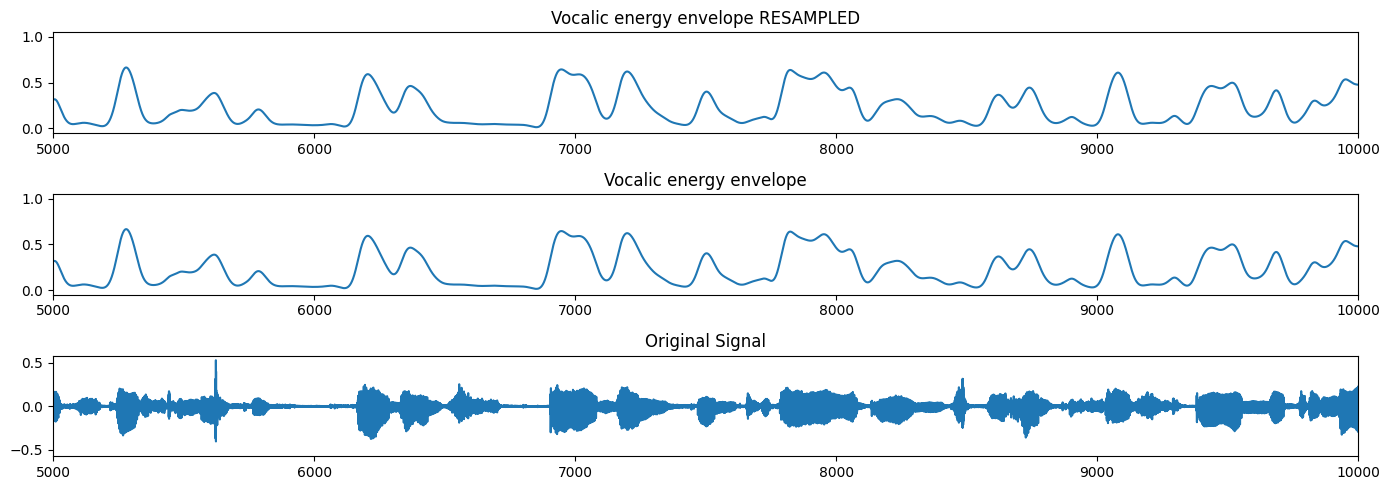

In [46]:
# lets extract the amplitude envelope of the vocalic energy from the audio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import librosa
import librosa.display

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the lowpass filter
def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    # load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None)
    # Bandpass filter 400-4000Hz
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    # Lowpass filter 10Hz
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    # scale from 0 to 1
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

# load in audio
ampv, sr = amp_envelope(audiofile)
rawaudio, sr = librosa.load(audiofile, sr=sr)

print("sampling rate original: " + str(sr))
# Create DataFrame with time in ms and envelope
ENV = pd.DataFrame({'time_ms': (np.arange(0, len(ampv))/sr)*1000, 'env': ampv})

# Create regular time points every 10ms
target_times = np.arange(0, ENV['time_ms'].max(), 10)
# Interpolate the envelope values at these times
ENVfinal = pd.DataFrame({
    'time_ms': target_times,
    'env': np.interp(target_times, ENV['time_ms'], ENV['env'])
})

# Save to CSV
ENVfinal.to_csv(inputfolder + name + 'env.csv', index=False)
######################################## Create time arrays for plotting
time_ampv = np.arange(len(ampv))/sr*1000   # Time array for ampv
time_raw = np.arange(len(rawaudio))/sr*1000  # Time array for raw audio

# Plot the amplitude envelope resampled
plt.figure(figsize=(14, 5))
plt.subplot(3, 1, 1)
plt.plot(ENV['time_ms'], ENV['env']) 
plt.title('Vocalic energy envelope RESAMPLED')
plt.xlim(5000, 10000)  

# Plot the filtered signal
plt.subplot(3, 1, 2)
plt.plot(time_ampv, ampv)
plt.title('Vocalic energy envelope')
plt.xlim(5000, 10000)

#make a third plot
plt.subplot(3, 1, 3)
plt.plot(time_raw, rawaudio)
plt.title('Original Signal')
plt.xlim(5000, 10000)

plt.tight_layout()
plt.show()

In [47]:
ENV = pd.read_csv(inputfolder + name + 'env.csv')

print("The data for the amplitude envelope have " + str(ENV.shape[1]) + 
      " columns, sampling at " + 
      str(round(ENV['time_ms'].diff().median())) + " ms intervals")
ENV.head()

The data for the amplitude envelope have 2 columns, sampling at 10 ms intervals


time_ms       env
0      0.0  0.027660
1     10.0  0.027599
2     20.0  0.027543
3     30.0  0.027537
4     40.0  0.027653

In [48]:
print("And the annotations of gestures of the right hand, with start_time, end_time, and annotation information. In total we have " + str(ANNO.shape[0]) + " annotations,")
ANNO.head()

And the annotations of gestures of the right hand, with start_time, end_time, and annotation information. In total we have 40 annotations,


start_time  end_time  labelid    label  duration
0        8.00      8.92        1  Gesture      0.92
1       11.84     12.48        2  Gesture      0.64
2       12.96     14.80        3  Gesture      1.84
3       18.84     20.40        4  Gesture      1.56
4       30.88     31.28        5  Gesture      0.40

## Select MT and merge with acoustic envelope data
Lets not merge all data. For the motion tracking output we generated for the cartoon video we are now only interested in some specific body part; say we are interested in the right hand index finger traces only. Lets select them first.

In [49]:
selection = ["time", "X_RIGHT_INDEX", "Y_RIGHT_INDEX" ,"Z_RIGHT_INDEX"] #concatenate some variable names in a list called "selection"
MTs = MT[selection]

This selection of the motion tracking data we want to then align with the acoustic data. We use pandas merge function for this, and we align the acoustic and motion tracking data based on their common information (namely time in milliseconds). We do we want to make sure that we keep information from both objects, instead of only aligning when one and the other has a value (we therefore set how = "outer" as this is callled an outer join where all rows of both dataframes will be merged with ).

In [50]:
# before merging lets rename the column time_ms in env to time so that they get properly merged into one column
ENV = ENV.rename(columns={'time_ms': 'time'})

# Merge the data frames using an outer join
merged = pd.merge(MTs, ENV, on ='time', how='outer')
# Sort the dataframe by Time1 and Time2
merged = merged.sort_values(by=['time']) #lets order the dataframe along the time_ms
# Display the head of the merged data frame
print(merged.head())
# save
merged.to_csv(outputfolder + name + '_merged.csv', index=False)

           time  X_RIGHT_INDEX  Y_RIGHT_INDEX  Z_RIGHT_INDEX       env
0      0.000000            NaN            NaN            NaN  0.027660
4673  10.000000            NaN            NaN            NaN  0.027599
4674  20.000000            NaN            NaN            NaN  0.027543
4675  30.000000            NaN            NaN            NaN  0.027537
1     39.331367            NaN            NaN            NaN       NaN


We can see that while we have ordered and aligned the two objects in a single merge object, we have a lot of empty Non-Applicable (NaN) rows. This is because at the exact times the sample is taken for the amplitude envelope there is not a sample for motion tracking. The solution is to linearly interpolate and upsample your data. We will do this by approximating for each NaN for motion tracking sample what its value would be given that it is at time x and we know the values at a particular time before and after. Pandas has a native function for this. By stating which series you want to interpolate NaN's for (e.g., X_RIGHT_INDEX), given some information about the time (x = time). We can leave NaN's that we aren't able to interpolate, e.g., if your merged time series ends with NaN's we cant interpolate because we dont have values we can use for interpolation.  


In [51]:
# Perform interpolation for specified columns
merged['X_RIGHT_INDEX'] = merged['X_RIGHT_INDEX'].interpolate(method='linear', x=merged['time'])
merged['Y_RIGHT_INDEX'] = merged['Y_RIGHT_INDEX'].interpolate(method='linear', x=merged['time'])
merged['Z_RIGHT_INDEX'] = merged['Z_RIGHT_INDEX'].interpolate(method='linear', x=merged['time'])
# Alternatively, perform interpolation for all columns
# merged.iloc[:, 2:5] = merged.iloc[:, 2:5].interpolate(method='linear', x = merged['time_ms'])
# save
merged.to_csv(outputfolder + name + '_merged_step1.csv', index=False)

We are now almost done with the merging of acoustics and motion tracking. First, we should note, that there is an important reason why we choose to upsample the motion tracking data from 30Hz to 100Hz, and this is because we would be loosing information if we would downsample the amplitude envelope from 100Hz to 30Hz.   

Now that we have upsampled the motion tracking data, we can just go ahead and only keep information where we both have info from the amplitude envelope and info from motion tracking; this will yield a time series object with steadily samples at 100Hz with original data points for the amplitude envelope, and interpolated and upsampled values for the motion tracking (we discard the original samples from the motion tracking).

In [52]:
# Remove rows with NA values in the 'env' column
merged = merged.dropna(subset=['env'])

# Remove trailing NA values
merged = merged.dropna(subset=['X_RIGHT_INDEX'])

# make sure that the indices are set from 0 to n
merged = merged.reset_index()

# only keep the following columns
tokeep = ['time', 'X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX', 'env']
# Display the updated DataFrame
merged = merged[tokeep]

merged.head() #lets look at what we created so far

# save again
merged.to_csv(outputfolder + name + '_merged_step2.csv', index=False)


## Inspecting data, deriving some motion tracking measures, and applying smoothing

So we now have a 'merged' data file that contains fully time aligned data about movement and acoustics. Our first multimodal time series object! Lets do some plotting of the amplitude envelope against the position traced we have of the index finger for an arbitrary 5 second sample.


In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming you have a DataFrame named 'merged', were taking a subsample from it
sample = merged[merged['time'].between(25000, 35000)]

# Create the first plot
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=sample['time'], y=sample['env'], mode='lines'))

# Create the second plot
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=sample['time'], y=sample['Z_RIGHT_INDEX'], name='z', mode='lines', line=dict(color='red')))
fig2.add_trace(go.Scatter(x=sample['time'], y=sample['Y_RIGHT_INDEX'], name='y', mode='lines', line=dict(color='gold')))
fig2.add_trace(go.Scatter(x=sample['time'], y=sample['X_RIGHT_INDEX'], name='x', mode='lines', line=dict(color='blue')))

# Create subplots
fig = make_subplots(rows=2, cols=1, subplot_titles=('Envelope', 'x, y, z displacement'))

# Add the plots to the subplots
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)
fig.add_trace(fig2.data[1], row=2, col=1)
fig.add_trace(fig2.data[2], row=2, col=1)

# Update the subplots layout
fig.update_layout(showlegend=False)

# Display the subplots
fig.show()

### Smoothing

One thing that you will run into when using motion tracking data, especially when using video based motion tracking data, is that you will have noise-related jitter in your time series. At some times such noise maybe minimal, e.g., when using very accurate device-based motion tracking devices. But in other cases, you will see that there are sudden jumps or kinks from time point to time point due to tracking inaccuracies (that can be caused by occlusions, or not ideal lighting, camara position changes, etc.).

It is good therefore to apply some smoothing to the position traces of your motion tracking data, as well as any derivatives that are approximated afterwards (e.g., 3D speed, vertical velocity). You can for example apply a low-pass filter, whereby you try to only allow fluctuations that have a slow frequency change (gradual changes from point to point) so as to filter out (i.e., reduce the amplitude of) the jitter that occurs at very high frequencies (because they result in sudden changes from point to point). Note that when using low-pass filters there can be some time shift, so in that case it is good to undo that shift by running the smoothing forwards and backwards (we do this by using filtfilt); this undoing of distortions in time is called a “zero-phase” low-pass filter. Applying zero-phase low-pass filters is important if you care about precise temporal precision relative to some other timeseries for example (e.g., acoustics).

We can also use a different kind of smoothing filter where the cut-off frequency is not strictly defined such as a running weighted average or Gaussian filter, such that sudden changes in the time series are smoothed out by relating them in some weighted way to the neighboring data points. Below we use such a neighbor averaging filter called a Gaussian filter.

So we provide two filters, and we also show some differences in settings. The amount of possible filters is immense. To pick one filter without becoming an expert on filters (but see [2] chapter 4 for a really nice resource to read up on this), you can try a few and then assess it with your own data and see how a filter is capturing the variability you are interested in (for example by checking against the video of the movements). If you care about small amplitude fluctuations in your time series that might have to do with jerky movement, a heavy filter can potentially destroy this variability. A too weak of a filter might leave the signal riddled with noise, which may look acceptable, but can cascade into dramatic noisy estimates when taking for example derivatives as they amplify power at faster frequencies (e.g., speed -> acceleration -> jerk) (see e.g., [3] chapter 3 for a nice discussion on this). There are also ways to empirically assess what high frequency noise is in the data, given that noise generally has a particular random structure (see [2]).

As an excercise, try to play with the parameters of the smoothing functions a little, and zoom in on the graph, to see what effects it has. 

In [54]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

# Butterworth filter function
    #take some time series, apply the filter, then return it 
def butter_it(x, sampling_rate, order, lowpass_cutoff):
    nyquist = sampling_rate / 2
    cutoff = lowpass_cutoff / nyquist  # Normalized frequency
    b, a = butter(order, cutoff, btype='low')
    filtered_x = filtfilt(b, a, x)
    return np.asarray(filtered_x, dtype=np.float64)

# set Gaussian filter 
guassian_sigma = 2.0  # Standard deviation

# make a new throwaway dataframe
tempmerge = merged

# we can see more dramatic effects of the smoothing when we add some noise to the time series
    # Add Gaussian noise
mean = 0  # Mean of the Gaussian distribution
std_dev = 0.001  # Standard deviation of the Gaussian distribution
noise = np.random.normal(mean, std_dev, size=len(tempmerge['Z_RIGHT_INDEX']))
tempmerge['Z_RIGHT_INDEX']  = tempmerge['Z_RIGHT_INDEX'] + noise

# Add a heavy filter with lowpass cutoff 10
tempmerge['Z_RIGHT_INDEXlowpass10'] = butter_it(tempmerge['Z_RIGHT_INDEX'], sampling_rate=100, order=1, lowpass_cutoff=10)

# Add a milder filter with lowpass cutoff 30
tempmerge['Z_RIGHT_INDEXlowpass30'] = butter_it(tempmerge['Z_RIGHT_INDEX'], sampling_rate=100, order=1, lowpass_cutoff=30)

# Also add a guassian filter (sigma is the standard deviation of the guassian)
tempmerge['Z_RIGHT_INDEXguassianfilt'] = gaussian_filter1d(tempmerge['Z_RIGHT_INDEX'], sigma = 2)

# Create the plot using Plotly Express (px)
# Create the second plot 
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=tempmerge['time'], y=tempmerge['Z_RIGHT_INDEX'], name='z raw', mode='lines', line=dict(color='black')))
fig3.add_trace(go.Scatter(x=tempmerge['time'], y=tempmerge['Z_RIGHT_INDEXlowpass10'], name='z smooth 10 Hz', mode='lines', line=dict(color='red')))
fig3.add_trace(go.Scatter(x=tempmerge['time'], y=tempmerge['Z_RIGHT_INDEXlowpass30'], name='z smooth 30 Hz', mode='lines', line=dict(color='gold')))
fig3.add_trace(go.Scatter(x=tempmerge['time'], y=tempmerge['Z_RIGHT_INDEXguassianfilt'], name='z smooth Guassian', mode='lines', line=dict(color='green')))

# Create subplots
fig3.show()


So in the above figures you can zoom in see the differences between different kind of filter settings. Our Mediapipe tracking sample is already quite smooth, but in our experience video based motion tracking can be quite jittery and smoothing is crucial then. For now we will apply for all our motion tracking data the 2nd order zero-phase butterworth filter at a frequency cutoff of 20Hz.

In [55]:
#apply a butterworth filter to the following position traces
cs = ['X_RIGHT_INDEX', 'Y_RIGHT_INDEX','Z_RIGHT_INDEX']
merged[cs] = merged[cs].apply(lambda x: butter_it(x=x,sampling_rate=100, order=2, lowpass_cutoff=20))


### Computing speed and acceleration (and smoothing again)

We now already have only for one body joint three variables to describe its position. Sometimes we are only interested in a 1-dimensional signal, such as rate of position change in a particular dimension (e.g., vertical velocity), or the rate of change of position in any direction (3D speed), or the change of 3D speed (acceleration). Below some simple examples of how to compute this from your initial position data using forward differientiation.

In [56]:
# function that differientates and butterworth filters the speed vector
def derive_it(x):
    x = np.concatenate(([0], np.diff(x)))
    x= butter_it(x, sampling_rate=100, order=2, lowpass_cutoff=20)
    return x

# function to calculate the speed vector
def get_speed_vector(x, y, z, time_millisecond):
    # calculate the Euclidean distance from time point x to time point x+1, for 3 dimensions
    speed = np.concatenate(([0], np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2 + np.diff(z) ** 2)))
    speed = butter_it(speed, sampling_rate=100, order=2, lowpass_cutoff=20)

    # scale the speed vector so that we express it units change per second change
    time_diff = np.mean(np.diff(time_millisecond)) / 1000
    speed = speed / time_diff
    return speed

# function to scale the time series
def sc_it(x):
    return (x - np.mean(x)) / np.std(x, ddof=0)

#make a new variable in a pandas dataframe
merged['speed'] = get_speed_vector(merged['X_RIGHT_INDEX'], merged['Y_RIGHT_INDEX'], merged['Z_RIGHT_INDEX'], merged['time'])
merged['vertical_velocity'] = derive_it(merged['Y_RIGHT_INDEX'])/np.mean(np.diff(merged['time']))
merged['acceleration'] = derive_it(merged['speed'])
merged['jerk'] = derive_it(merged['acceleration'])

cs = ['speed', 'vertical_velocity', 'acceleration', 'jerk']
merged[cs] = merged[cs].apply(lambda x: sc_it(x))


# Create the plot using Plotly Express (px)
# Create the second plot
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=merged['time'], y=merged['speed'], name='speed', mode='lines', line=dict(color='black')))
fig4.add_trace(go.Scatter(x=merged['time'], y=merged['vertical_velocity'], name='vertical velocity', mode='lines', line=dict(color='red')))
fig4.add_trace(go.Scatter(x=merged['time'], y=merged['acceleration'], name='acceleration', mode='lines', line=dict(color='gold')))
fig4.add_trace(go.Scatter(x=merged['time'], y=merged['jerk'], name='jerk', mode='lines', line=dict(color='green')))
# show only a portion of the plot for the x axis
fig4.update_xaxes(range=[52200, 71600])
fig4.show()

# save the intermediate step
merged.to_csv(outputfolder + name + '_merged_step3.csv', index=False)

Note. Notice for the figure that vertical velocity can go positive (upward rate of motion) or negative (downward rate of motion); it is a vector as the values have a direction. This is similar for acceleration (positive = acceleration, negative = deceleration) and jerk (positive = increasing acceleration, negative = decreasing acceleraiton). Speed is a scalar value and does not go negative.

# Adding annotations and saving data
We now have merged the acoustic data with an upsampled selection of the motion tracking data, and we have derived some kinematic variables and added them to our time series dataset. The only thing that is left, is to merge the annotations with this dataset. The following code loads in the annotations (with start_time, end_time, and annotation) in the time series data. We also add an identifier to the gesture coding, such that each gesture event gets a unique identifier.


In [63]:
# load the most recent merged
merged = pd.read_csv(outputfolder + name + '_merged_step3.csv')
# load annotations and set time to ms
annotationfile = glob.glob(inputfolder + "*_segments.csv")[0]
ANNO = pd.read_csv(annotationfile)
ANNO['start_time'] = ANNO['start_time'] * 1000
ANNO['end_time'] = ANNO['end_time'] * 1000

def load_in_event(time_original, anno, columnstoadd):
    """
    Load annotations into a DataFrame matching the original time series.
    Returns:
    DataFrame with same length as time_original, containing annotation data
    """
    # Create output DataFrame with same index as original time series
    output = pd.DataFrame(index=range(len(time_original)))
    
    # Add each requested column
    for col in columnstoadd:
        output[col] = np.full(len(time_original), np.nan, dtype=object)
        # For each annotation
        for i in range(len(anno)):
            # Find time points that fall within this annotation's time window
            selection = (time_original >= anno.loc[i, 'start_time']) & (time_original <= anno.loc[i, 'end_time'])
            # Assign the corresponding value from the annotation
            output.loc[selection, col] = anno.loc[i, col]
    
    return output

# apply the function to the merged dataframe
columnstoadd=['labelid', 'label']
merged[columnstoadd] = load_in_event(merged['time'], ANNO, columnstoadd=columnstoadd)
#lets save the data now we have everything merged
merged.to_csv(outputfolder+'merged_finalstep.csv', index=False)


In [60]:
merged.head()

time  X_RIGHT_INDEX  Y_RIGHT_INDEX  Z_RIGHT_INDEX       env  \
0  6260.0       0.468139       0.363168       0.020073  0.354891   
1  6270.0       0.471064       0.351013      -0.022420  0.298717   
2  6280.0       0.474102       0.338388      -0.070301  0.246130   
3  6290.0       0.477064       0.326089      -0.127784  0.201790   
4  6300.0       0.479374       0.316535      -0.190344  0.175819   

   Z_RIGHT_INDEXlowpass10  Z_RIGHT_INDEXlowpass30  Z_RIGHT_INDEXguassianfilt  \
0                0.019672                0.020073                  -0.034246   
1               -0.027896               -0.024886                  -0.053576   
2               -0.076974               -0.068273                  -0.088922   
3               -0.129445               -0.124468                  -0.134811   
4               -0.183490               -0.194605                  -0.185108   

      speed  vertical_velocity  acceleration      jerk labelid label  
0 -0.900748           0.001819      0.000221  0.000108     NaN   NaN  
1  3.943532          -2.549440      8.637715  5.783995     NaN   NaN  
2  6.981130          -3.811325     10.222705  3.522186     NaN   NaN  
3  8.179316          -3.655029      5.912964 -3.537889     NaN   NaN  
4  8.299620          -2.699369      0.957500 -7.634063     NaN   NaN

# Some applications
So this new merged dataset is very flexible, in that we can for example, loop through relevant events and extract information from it. For example in the below lines of code, we ask for each gesture what the peak speed was, and then also the maximum in the amplitude envelope, and their timings. We then calculate the time difference between the speech and the movement peaks (synchrony). We then provide a smoothed frequency distribution to see how the timing distribution per gesture type.

## peak analysis

In [67]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Example plot
    # pick an example gesture ID
pickedexample_indices = merged[merged['labelid'] == merged['labelid'].unique()[2]].index
    # pick the time series chunck for that gesture ID
sample_ts = merged.loc[pickedexample_indices]
    # pick the max speed value and time, same for the max env value and time
maxspeed_value = sample_ts['speed'].max()
maxspeed_time = sample_ts.loc[sample_ts['speed'].idxmax(), 'time']
maxenv_value = sample_ts['env'].max()
maxenv_time = sample_ts.loc[sample_ts['env'].idxmax(), 'time']
    # make the plot
fig = make_subplots(rows=1, cols=2)
    # add the traces
fig.add_trace(
    go.Scatter(x=sample_ts['time'], y=sample_ts['speed'], mode='lines', name='speed'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=[maxspeed_time], y=[maxspeed_value], mode='markers', marker=dict(color='red', size=8), name='max speed'),
    row=1, col=1
)
fig.add_vline(x=maxenv_time, line_color='purple', line_dash='dash', row=1, col=1)
fig.add_vline(x=maxspeed_time, line_color='red', line_dash='dash', row=1, col=1)

fig.add_trace(
    go.Scatter(x=sample_ts['time'], y=sample_ts['env'], mode='lines', name='env'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=[maxenv_time], y=[maxenv_value], mode='markers', marker=dict(color='purple', size=8), name='max env'),
    row=1, col=2
)
# add vertical lines that match the time of each peak
fig.add_vline(x=maxenv_time, line_color='purple', line_dash='dash', row=1, col=2)
fig.add_vline(x=maxspeed_time, line_color='red', line_dash='dash', row=1, col=2)

fig.update_xaxes(title_text='time', row=1, col=1)
fig.update_yaxes(title_text='speed', row=1, col=1)
fig.update_xaxes(title_text='time', row=1, col=2)
fig.update_yaxes(title_text='env', row=1, col=2)
fig.update_layout(title='label', showlegend=False)
fig.show

In [82]:

# Apply routine to the whole dataset
maxs = []
maxenv = []
maxst = []
maxenvt = []
label = []
g_ID = []

for id in merged['labelid'].unique():
    if pd.notnull(id):
        indices = merged[merged['labelid'] == id].index
        slicemerged = merged.loc[indices]
        maxs.append(slicemerged['speed'].max())
        maxst.append(slicemerged.loc[slicemerged['speed'].idxmax(), 'time'])
        maxenv.append(slicemerged['env'].max())
        maxenvt.append(slicemerged.loc[slicemerged['env'].idxmax(), 'time'])
        label.append(slicemerged['label'].unique()[0])
        g_ID.append(slicemerged['labelid'].unique()[0])

mag_D = pd.DataFrame({
    'maxs': maxs,
    'maxenv': maxenv,
    'maxst': maxst,
    'maxenvt': maxenvt,
    'label': label,
    'g_ID': g_ID
})
mag_D['synchrony'] = mag_D['maxst'] - mag_D['maxenvt']

# plot the relationship between speed and env
fig = go.Figure()
fig.add_trace(go.Scatter(x=mag_D['maxenv'], y=mag_D['maxs'], mode='markers', text=mag_D['label']))
fig.update_xaxes(title_text='max env')
fig.update_yaxes(title_text='max speed')
# add linear regression slope
m, b = np.polyfit(mag_D['maxenv'], mag_D['maxs'], 1)
fig.add_trace(go.Scatter(x=mag_D['maxenv'], y=m * mag_D['maxenv'] + b, mode='lines', name='fit'))
fig.show()

# print the correlation and p-value
from scipy.stats import pearsonr
corr, p = pearsonr(mag_D['maxenv'], mag_D['maxs'])
print('Pearsons correlation: %.3f' % corr)
print('p-value: %.3f' % p)
    


Pearsons correlation: 0.484
p-value: 0.002


In [81]:
# lets also plot the timing of the max speed and max env (synchrony) as a density plot 
fig = ff.create_distplot([mag_D['synchrony']], group_labels=['synchrony'], bin_size=1000)
fig.update_xaxes(title_text='synchrony')
fig.update_yaxes(title_text='density')
fig.show()

## References
1. [Pouw, W., Trujillo, J. P., & Dixon, J. A. (2020). The quantification of gesture–speech synchrony: A tutorial and validation of multimodal data acquisition using device-based and video-based motion tracking. Behavior research methods, 52(2), 723-740.](https://link.springer.com/article/10.3758/s13428-019-01271-9)
2. [Challis, J. H. (2020). Experimental Methods in Biomechanics. Springer Nature.](https://link.springer.com/book/10.1007/978-3-030-52256-8)
3. [Winter, A. (2009). Biomechanics and Motor Control of Human Movement. Wiley & Sons.](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470549148)